# 20기 Time Series 정규세션 과제

### Electric_Production.csv 데이터를 활용하여 자유롭게 시계열분석을 진행해주세요.
첨부한 '시계열자료_실습.ipynb' 코드를 참고하셔도 좋습니다.


### Box-Jenkins 방법론
![image.png](attachment:image.png)

### Prophet
튜토리얼 : https://hyperconnect.github.io/2020/03/09/prophet-package.html

## 라이브러리 불러오기

In [1]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.8 MB/s eta 0:00:00


In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas import datetime
from statsmodels.tsa.arima.model import ARIMAResults

<ipython-input-2-9e8c74a226ca>:13: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


## 데이터 불러오기

In [3]:
samsung_df = yf.download('005930.KS',
                      start='2020-01-01',
                      end='2021-04-21',
                      progress=False)

samsung_df = samsung_df[["Close"]]

samsung_df = samsung_df.reset_index()

samsung_df.columns = ['day', 'price']

samsung_df['day'] = pd.to_datetime(samsung_df['day'])

samsung_df.index = samsung_df['day']
samsung_df.set_index('day', inplace=True)

samsung_df

,price
day,
2020-01-02,55200.0
2020-01-03,55500.0
2020-01-06,55500.0
2020-01-07,55800.0
2020-01-08,56800.0
...,...
2021-04-14,84000.0
2021-04-15,84100.0
2021-04-16,83900.0


#1. 식별

정상성 확인, 정상화

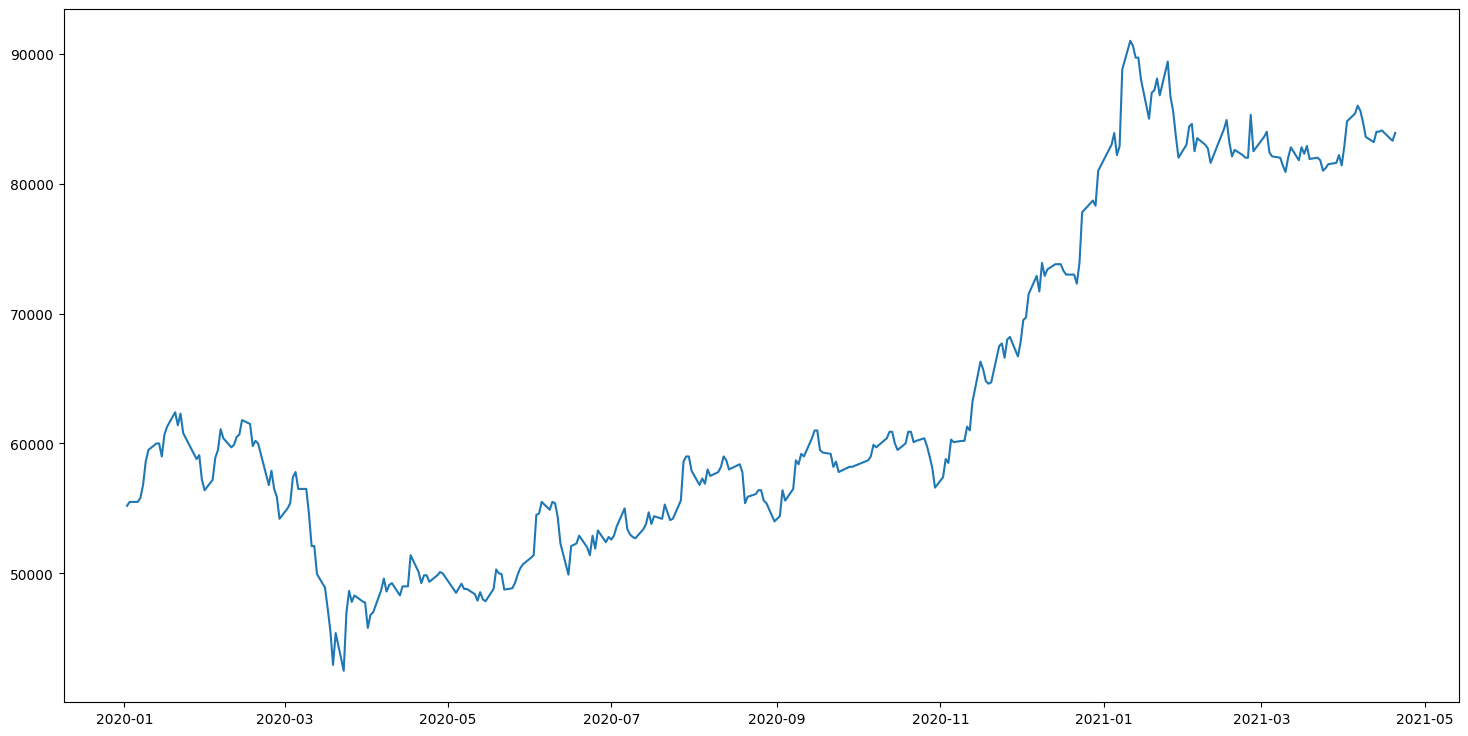

In [4]:
plt.figure(figsize=(18,9))
plt.plot(samsung_df.index, samsung_df["price"], linestyle="-")
plt.xlabel=('Dates')
plt.ylabel=('Total Price')
plt.show()

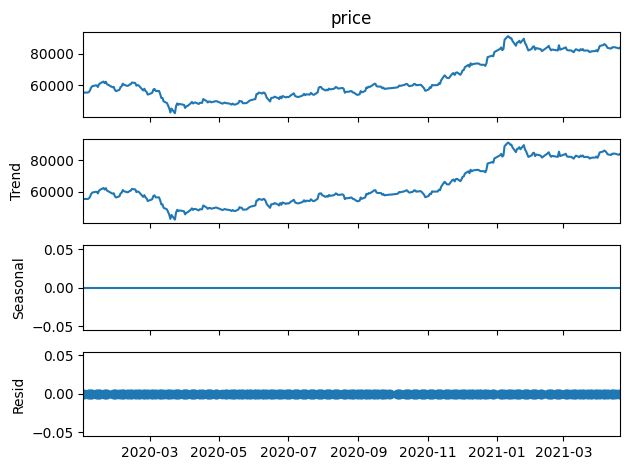

In [5]:
decompose = seasonal_decompose(samsung_df['price'], model='addictive', period=1).plot()

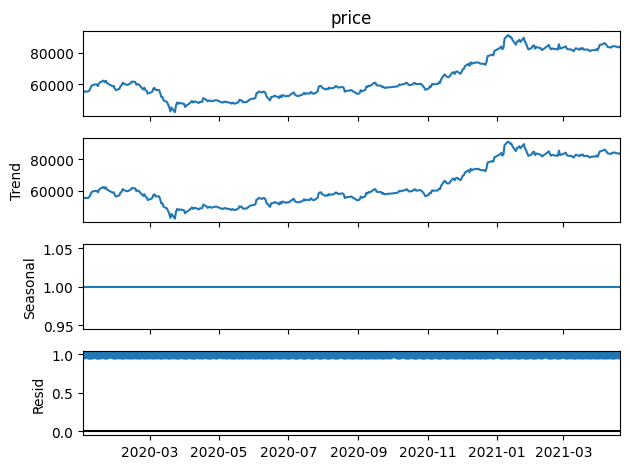

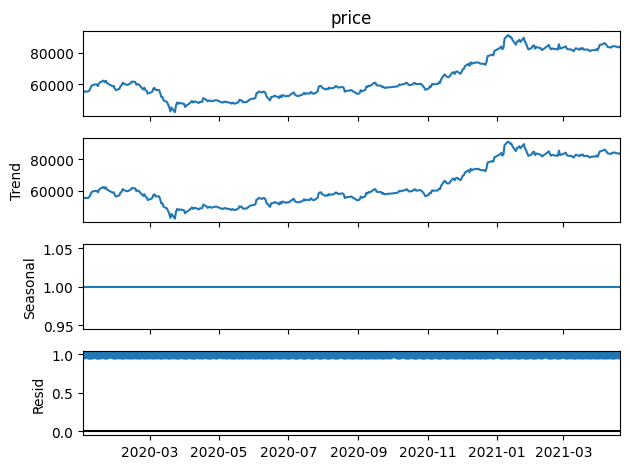

In [6]:
seasonal_decompose(samsung_df['price'], model='multiplicative', period=1).plot()

In [7]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(samsung_df, test_size=0.2, shuffle=False)

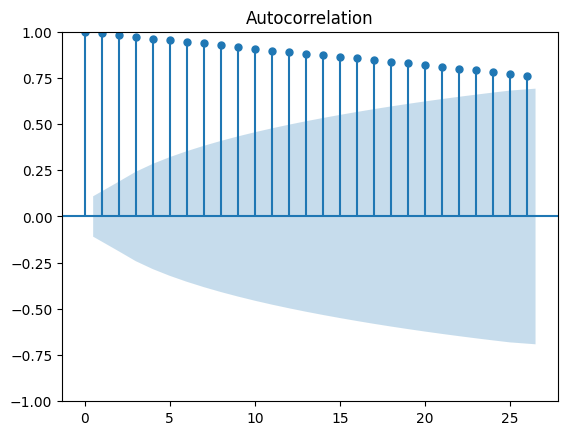

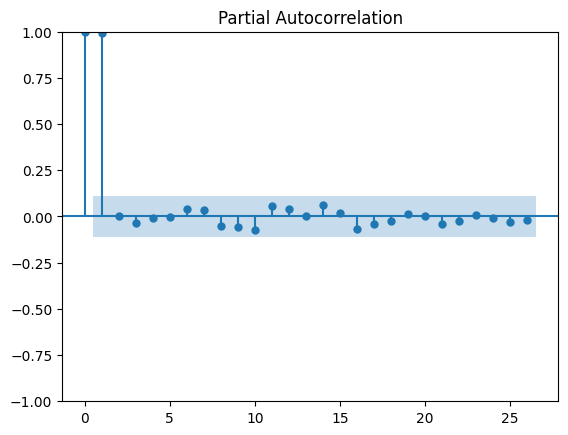

In [8]:
plot_acf(samsung_df['price'])
plot_pacf(samsung_df['price'])
plt.show()

원본 데이터 시계열의 전체 분포, 분해 그래프, ACF, PACF 그래프를 확인해봤을 때 시계열 데이터의 정상성을 만족하지 않는 것으로 보인다. 따라서 차분을 진행하여 정상성을 만족해야 할 필요가 있어 보인다. \


이어서 ARIMA 모델의 d값을 구하기 위해 차분을 진행하도록 한다.

In [9]:
diff_samsung_df = samsung_df.copy()
diff_samsung_df = diff_samsung_df['price'].diff()
diff_samsung_df = diff_samsung_df.dropna()
print('**********Raw data**********')
print(samsung_df['price'].head())
print('**********Differenced data**********')
print(diff_samsung_df.head())

**********Raw data**********
day
2020-01-02    55200.0
2020-01-03    55500.0
2020-01-06    55500.0
2020-01-07    55800.0
2020-01-08    56800.0
Name: price, dtype: float64
**********Differenced data**********
day
2020-01-03     300.0
2020-01-06       0.0
2020-01-07     300.0
2020-01-08    1000.0
2020-01-09    1800.0
Name: price, dtype: float64


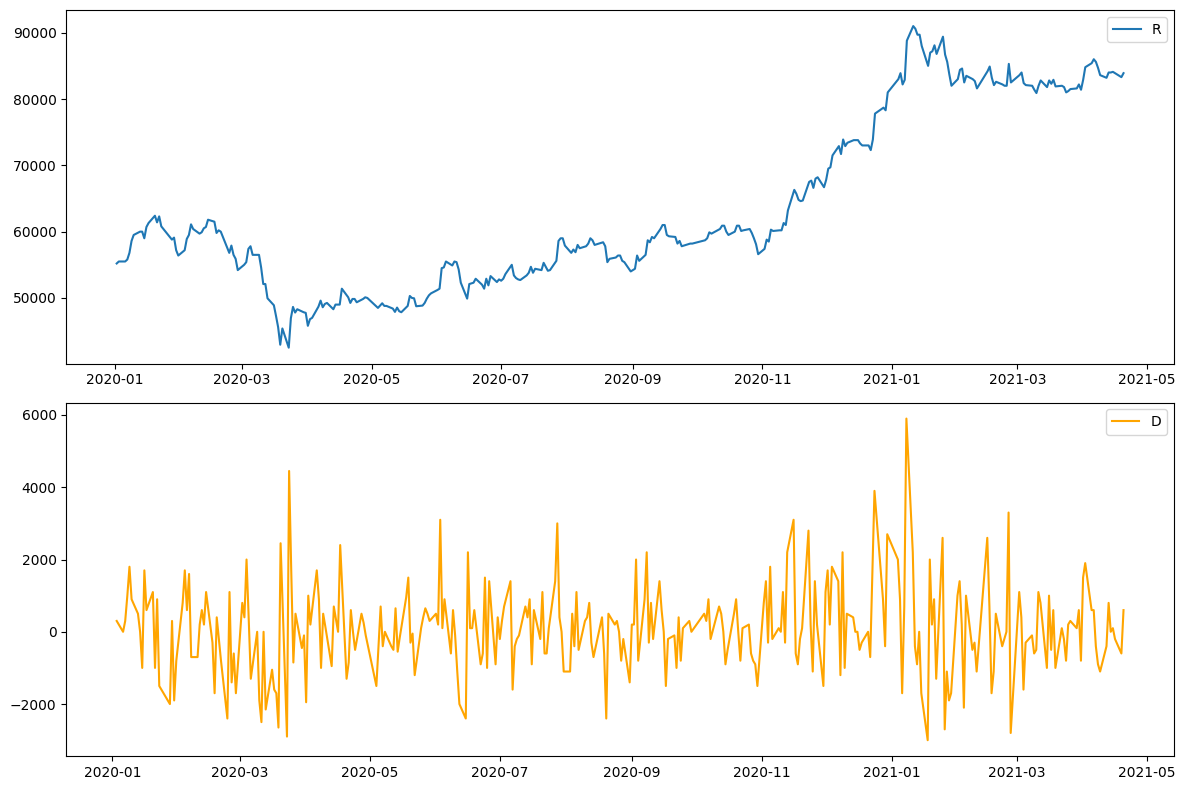

In [10]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

ax1.plot(samsung_df['price'])
ax1.legend('Raw data')

ax2.plot(diff_samsung_df, color='orange' )
ax2.legend('Differenced data')


plt.tight_layout()
plt.show()

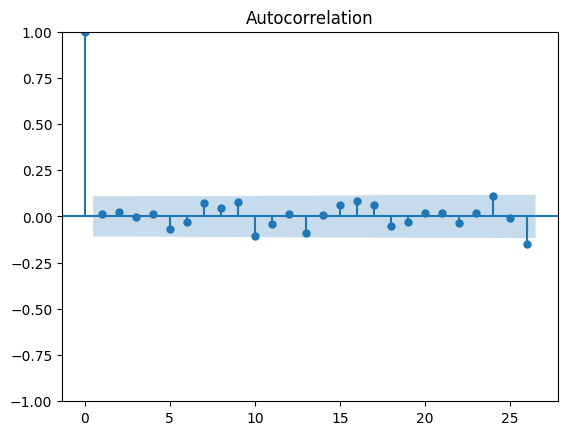

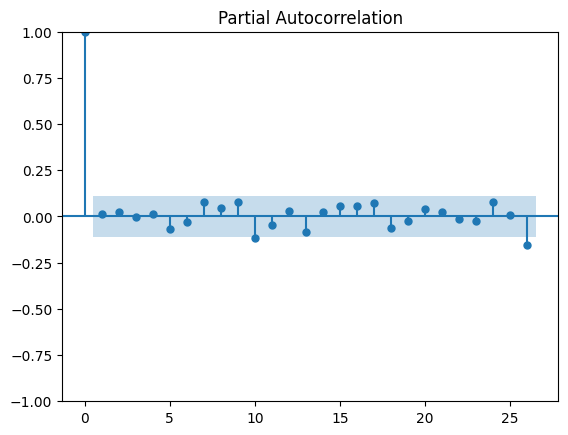

In [11]:
plot_acf(diff_samsung_df)
plot_pacf(diff_samsung_df)
plt.show()

차분을 1회 진행하여 시계열 데이터의 분포와 ACF, PACF를 살펴본 결과 차분을 1회만 진행하여도 시계열 데이터가 정상성을 만족하는 것을 확인할 수 있다. \
그리고 1차 차분 한 데이터의 ACF, PACF가 time lag 1 이후 0에 근접한 것을 볼 수 있으므로 ARIMA 모델의 (p, d, q) 값은 (0, 1, 0)이 적절해 보인다. 따라서 ARIMA(0, 1, 0)의 모델을 잠정적으로 채택한다.

#2. 추정
최소제곱법, 최대우도법, 비선형최소제곱법 등을 통한 모수 추정

ARIMA 모델 학습을 위한 train-test 데이터 분할한다. \

statsmodel의 arima 모듈을 통해 ARIMA 모델의 모수를 추정한다. \

In [12]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(samsung_df, test_size=0.2, shuffle=False)

In [13]:
ARIMA_model = ARIMA(train_data['price'], order=(0, 1, 0))
ARIMA_model_fit = ARIMA_model.fit()
print(ARIMA_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                  257
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -2181.513
Date:                Mon, 28 Aug 2023   AIC                           4365.027
Time:                        12:30:21   BIC                           4368.572
Sample:                             0   HQIC                          4366.452
                                - 257                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.471e+06   8.64e+04     17.024      0.000     1.3e+06    1.64e+06
Ljung-Box (L1) (Q):                   0.90   Jarque-Bera (JB):                73.91
Prob(Q):                              0.34   Pr

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


모수의 t-검정 값이 유의수준 0.05 이하이므로 sigma2 계수는 유효하다고 볼 수 있다. \

Ljung-Box에 대한 p-value인 Prob(Q) = 0.34 > 0.05이므로 잔차가 자기 상관을 가지지 않는다고 해석할 수 있다. \

또한 잔차의 이분산성에 대한 가설에 대한 p-value Prob(H) = 0.99 > 0.05 이므로 잔차가 이분산성을 띄지 않는다고 해석할 수 있다. \

마지막으로 잔차의 정규석 만족 가설에 대한 p-value Prob(JB) = 0.00 < 0.05 이므로 잔차가 정규성을 띄지 않는다고 해석이 된다.



#3. 진단
잔차의 시계열도, ACF, PACF 및 포트맨토 통계량을 이용한 잔차분석 \
AIC, SBC 등의 통계값을 이용해 가장 설명령 높은 모형 선택

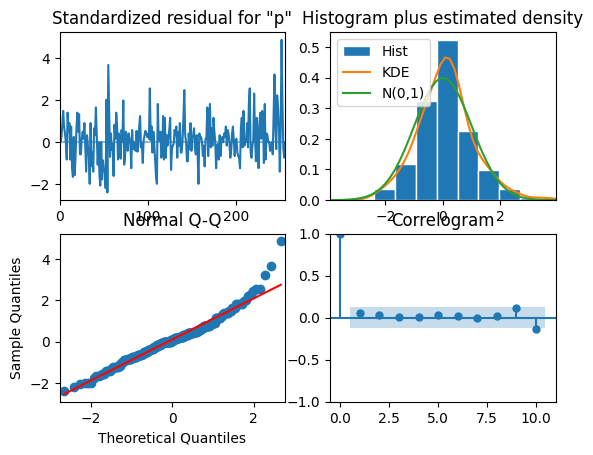

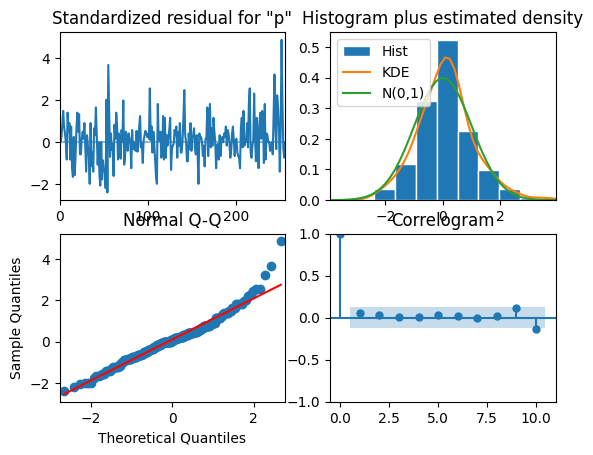

In [14]:
ARIMA_model_fit.plot_diagnostics()

학습한 ARIMA 모델의 잔차에 대한 진단 그래프를 살펴보았다. \

좌측 상단의 잔차의 시계열 데이터를 보았을 때 잔차의 시계열이 평균 0을 중심으로 변동하는 것으로 보이고, 우측 하단의 잔차의 ACF 그래프가 0 부근에 분포한 것을 보아 잔차의 정상성을 만족하는 것으로 보인다. \


우측 상단의 잔차의 히스토그램과 KDE가 정규분포 N(0, 1)와 비교했을 때 큰 차이가 없고, 좌측 하단의 Q-Q 그래프를 그렸을 때 잔차의 분포가 거의 빨간 색의 일직선 위에 위치하지만 오른쪽 끝 부분의 값이 이상치인 것을 볼 수 있다.

이번 시계열 분석에서는 잠정 모델이 ARIMA(0, 1, 0)으로 한 개의 경우밖에 나오지 않았지만, 잠정 모델이 여러 가지로 나오는 경우 AIC의 값 비교를 통해 최종적으로 잠정 모델을 채택할 수 있다.

In [15]:
import itertools

p = range(0, 3)
d = range(1, 3)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))

AIC = []
for i in pdq :
    model = ARIMA(train_data['price'].values, order=(i))
    model_fit = model.fit()
    print(f'ARIMA p, d, q : {i} >> AIC : {round(model_fit.aic, 2)}')
    AIC.append(round(model_fit.aic, 2))

ARIMA p, d, q : (0, 1, 0) >> AIC : 4365.03
ARIMA p, d, q : (0, 1, 1) >> AIC : 4366.44
ARIMA p, d, q : (0, 1, 2) >> AIC : 4368.33
ARIMA p, d, q : (0, 2, 0) >> AIC : 4507.08
ARIMA p, d, q : (0, 2, 1) >> AIC : 4477.9
ARIMA p, d, q : (0, 2, 2) >> AIC : 4460.09
ARIMA p, d, q : (1, 1, 0) >> AIC : 4366.41
ARIMA p, d, q : (1, 1, 1) >> AIC : 4365.97
ARIMA p, d, q : (1, 1, 2) >> AIC : 4368.0
ARIMA p, d, q : (1, 2, 0) >> AIC : 4489.37
ARIMA p, d, q : (1, 2, 1) >> AIC : 4454.09
ARIMA p, d, q : (1, 2, 2) >> AIC : 4455.4
ARIMA p, d, q : (2, 1, 0) >> AIC : 4368.28
ARIMA p, d, q : (2, 1, 1) >> AIC : 4367.97
ARIMA p, d, q : (2, 1, 2) >> AIC : 4370.0
ARIMA p, d, q : (2, 2, 0) >> AIC : 4480.6
ARIMA p, d, q : (2, 2, 1) >> AIC : 4458.29
ARIMA p, d, q : (2, 2, 2) >> AIC : 4461.38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [16]:
optim = [(pdq[i], j) for i, j in enumerate(AIC) if j == min(AIC)]
print('Found Optimal Parameter :',optim)

Found Optimal Parameter : [((0, 1, 0), 4365.03)]


잠정 채택한 (0, 1, 0) 파라미터의 ARIMA 모델이 가장 낮은 AIC 값을 갖는 것을 알 수 있다.

이로서 적합한 최종 모형이 도출됐다.

#3. 예측
적합한 최종모형으로 이후 값 예측

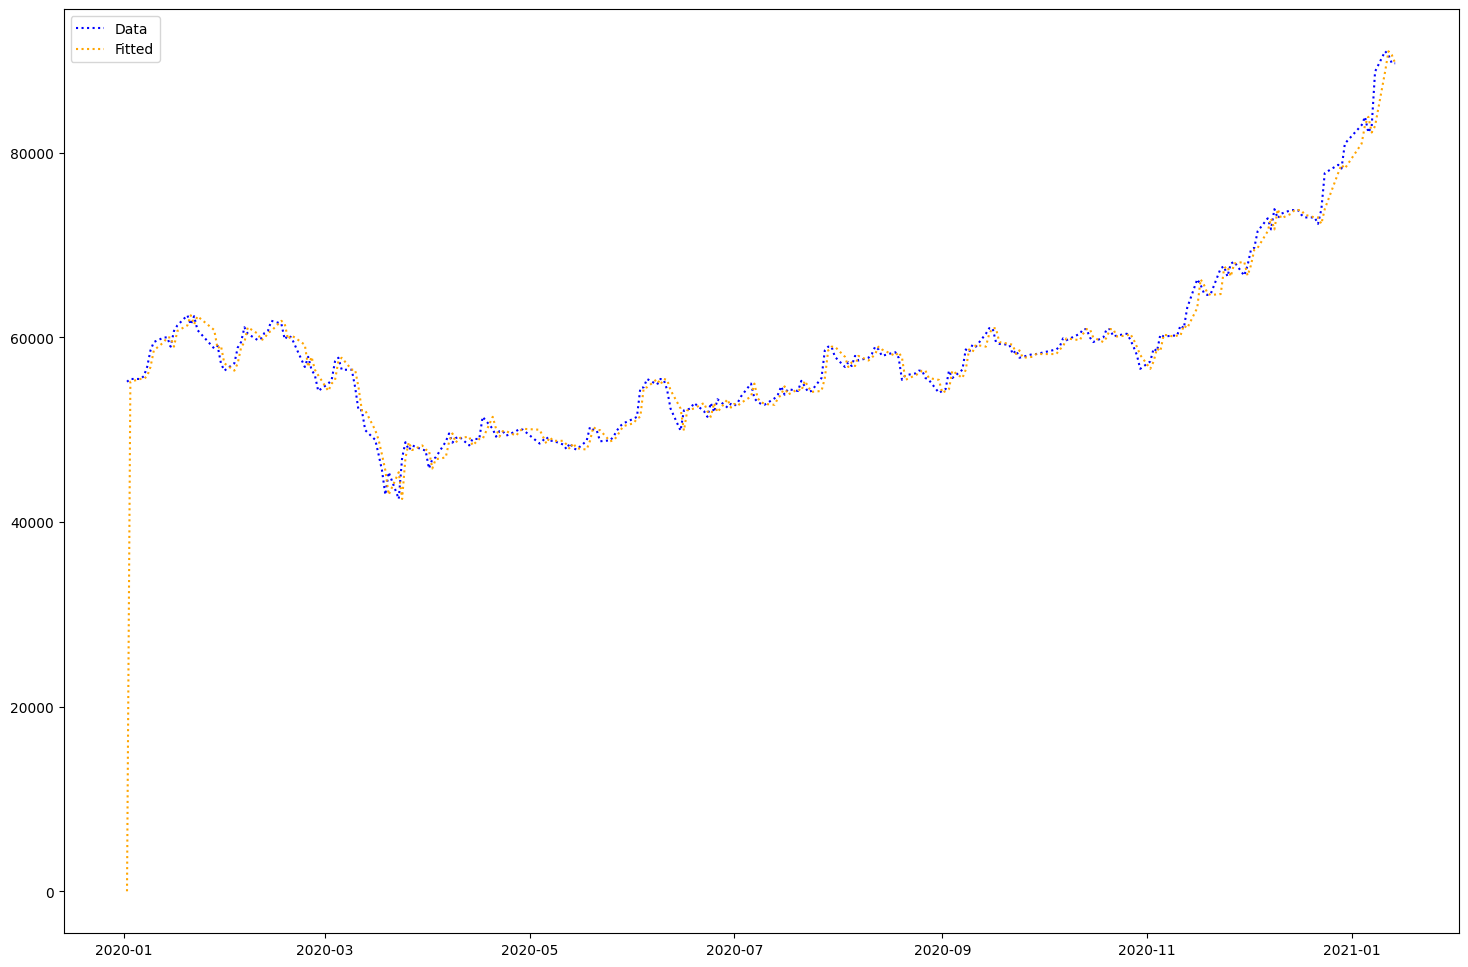

In [17]:
plt.figure(figsize=(18, 12))
plt.plot(train_data.index, train_data['price'], label = 'Data', color = 'blue', linestyle = ':')
plt.plot(train_data.index, ARIMA_model_fit.predict(), label = 'Fitted', color = 'orange', linestyle = ':')
plt.legend()
plt.show()

In [18]:
forecast_arima = ARIMA_model_fit.forecast(steps=len(test_data))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [19]:
forecast_arima

257    89700.0
258    89700.0
259    89700.0
260    89700.0
261    89700.0
        ...   
317    89700.0
318    89700.0
319    89700.0
320    89700.0
321    89700.0
Name: predicted_mean, Length: 65, dtype: float64

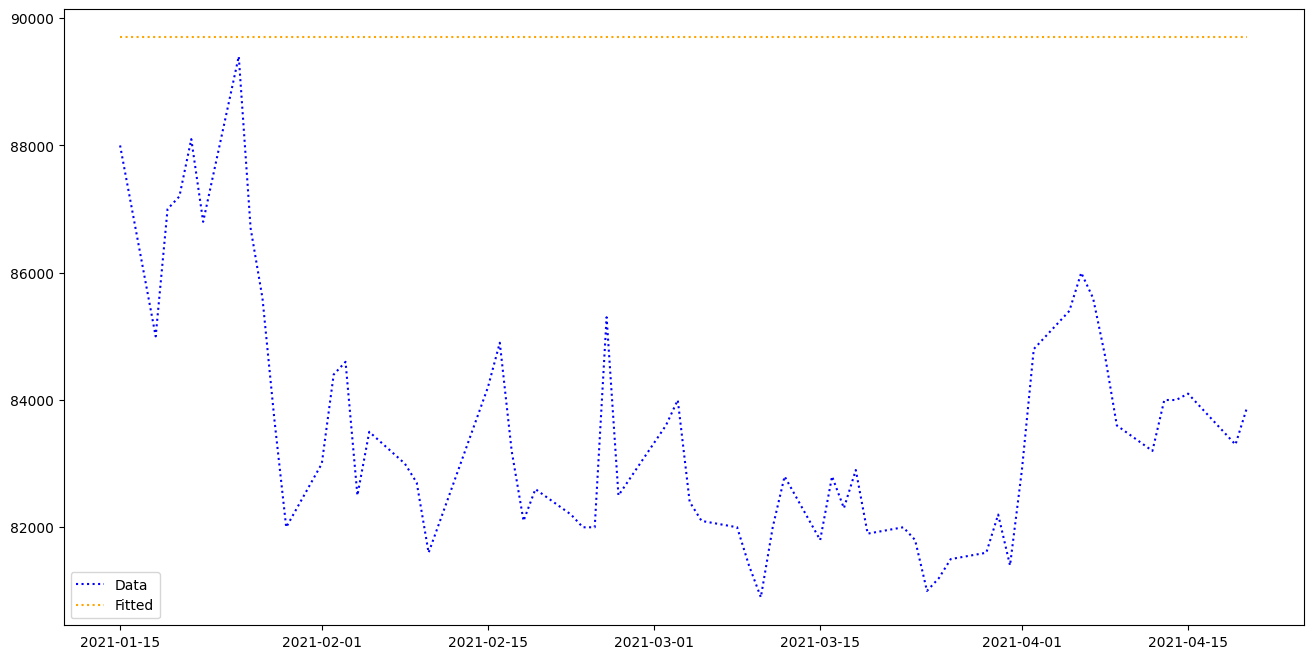

In [20]:
plt.figure(figsize = (16,8))
plt.plot(test_data.index, test_data['price'], label = 'Data', color = 'blue', linestyle = ':')
plt.plot(test_data.index, forecast_arima, label = 'Fitted', color = 'orange', linestyle = ':')
plt.legend()
plt.show()

In [21]:
from statsmodels.tools.eval_measures import rmse

arima_rmse_error = rmse(test_df['price'], forecast_arima)
arima_mse_error = arima_rmse_error**2
mean_value = samsung_df['price'].mean()

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')

MSE Error: 41388153.84615385
RMSE Error: 6433.362561379068
Mean: 63323.60248447205


모든 구간에 대해 예측값이 89700.0으로 동일하게 나왔다. \

box-jenkins 방법을 진행하면서 train 데이터에서는 모든 검정에 걸리는 것 없이 통과했지만, test데이터에 대해 굉장히 부족한 예측값을 내놓았다.

예측값이 이렇게 도출된 이유를 생각해보면, 우선 단변량 시계열로 주가예측을 진행하기에는 고려해야 할 외부요소들이 많기 때문임이 있을 것이다. \

따라서 더 정확한 예측을 위해선 다변량 데이터를 통해 시계열 예측을 진행하거나 더 복잡한 시계열 예측 모델이 필요하다. \

변수를 늘리긴 어려우므로 ARIMA 모델에서 계절성과 시계열에 영향을 주는 외부변수를  고려한 SARIMAX, 그리고 페이스북에서 발표한 Prophet 라이브러리를 사용해보겠다.

## SARIMAX

In [22]:
p = range(0, 3)
d = range(1, 2)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 10) for x in pdq]

AIC = []
params = []
for i in pdq :
    for j in seasonal_pdq :
        try :
            model = SARIMAX(train_data['price'].values, order=(i), seasonal_order = (j))
            model_fit = model.fit()
            print(f'SARIMA : {i},{j} >> AIC : {round(model_fit.aic, 2)}')
            AIC.append(round(model_fit.aic, 2))
            params.append((i, j))

        except Exception as e:
            print(e)
            continue

SARIMA : (0, 1, 0),(0, 1, 0, 10) >> AIC : 4384.36
SARIMA : (0, 1, 0),(0, 1, 1, 10) >> AIC : 4351.67
SARIMA : (0, 1, 0),(0, 1, 2, 10) >> AIC : 4347.99
SARIMA : (0, 1, 0),(1, 1, 0, 10) >> AIC : 4365.75
SARIMA : (0, 1, 0),(1, 1, 1, 10) >> AIC : 4343.55
SARIMA : (0, 1, 0),(1, 1, 2, 10) >> AIC : 4348.14
SARIMA : (0, 1, 0),(2, 1, 0, 10) >> AIC : 4367.26


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (0, 1, 0),(2, 1, 1, 10) >> AIC : 4345.45


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (0, 1, 0),(2, 1, 2, 10) >> AIC : 4347.57
SARIMA : (0, 1, 1),(0, 1, 0, 10) >> AIC : 4386.34
SARIMA : (0, 1, 1),(0, 1, 1, 10) >> AIC : 4353.6
SARIMA : (0, 1, 1),(0, 1, 2, 10) >> AIC : 4349.98
SARIMA : (0, 1, 1),(1, 1, 0, 10) >> AIC : 4363.8
SARIMA : (0, 1, 1),(1, 1, 1, 10) >> AIC : 4345.54
SARIMA : (0, 1, 1),(1, 1, 2, 10) >> AIC : 4353.32
SARIMA : (0, 1, 1),(2, 1, 0, 10) >> AIC : 4361.07
SARIMA : (0, 1, 1),(2, 1, 1, 10) >> AIC : 4347.29


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (0, 1, 1),(2, 1, 2, 10) >> AIC : 4346.46
SARIMA : (0, 1, 2),(0, 1, 0, 10) >> AIC : 4388.2
SARIMA : (0, 1, 2),(0, 1, 1, 10) >> AIC : 4359.98
SARIMA : (0, 1, 2),(0, 1, 2, 10) >> AIC : 4351.9
SARIMA : (0, 1, 2),(1, 1, 0, 10) >> AIC : 4365.28
SARIMA : (0, 1, 2),(1, 1, 1, 10) >> AIC : 4352.7
SARIMA : (0, 1, 2),(1, 1, 2, 10) >> AIC : 4349.25
SARIMA : (0, 1, 2),(2, 1, 0, 10) >> AIC : 4362.47
SARIMA : (0, 1, 2),(2, 1, 1, 10) >> AIC : 4349.22


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (0, 1, 2),(2, 1, 2, 10) >> AIC : 4349.46
SARIMA : (1, 1, 0),(0, 1, 0, 10) >> AIC : 4386.32
SARIMA : (1, 1, 0),(0, 1, 1, 10) >> AIC : 4358.23
SARIMA : (1, 1, 0),(0, 1, 2, 10) >> AIC : 4355.04
SARIMA : (1, 1, 0),(1, 1, 0, 10) >> AIC : 4363.48
SARIMA : (1, 1, 0),(1, 1, 1, 10) >> AIC : 4345.54
SARIMA : (1, 1, 0),(1, 1, 2, 10) >> AIC : 4352.9
SARIMA : (1, 1, 0),(2, 1, 0, 10) >> AIC : 4360.72
SARIMA : (1, 1, 0),(2, 1, 1, 10) >> AIC : 4352.89
SARIMA : (1, 1, 0),(2, 1, 2, 10) >> AIC : 4352.48


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


SARIMA : (1, 1, 1),(0, 1, 0, 10) >> AIC : 4388.33
SARIMA : (1, 1, 1),(0, 1, 1, 10) >> AIC : 4354.9
SARIMA : (1, 1, 1),(0, 1, 2, 10) >> AIC : 4357.41
SARIMA : (1, 1, 1),(1, 1, 0, 10) >> AIC : 4365.76


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (1, 1, 1),(1, 1, 1, 10) >> AIC : 4347.7


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (1, 1, 1),(1, 1, 2, 10) >> AIC : 4349.2
SARIMA : (1, 1, 1),(2, 1, 0, 10) >> AIC : 4363.03


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (1, 1, 1),(2, 1, 1, 10) >> AIC : 4349.32


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (1, 1, 1),(2, 1, 2, 10) >> AIC : 4351.18
SARIMA : (1, 1, 2),(0, 1, 0, 10) >> AIC : 4385.16
SARIMA : (1, 1, 2),(0, 1, 1, 10) >> AIC : 4361.77
SARIMA : (1, 1, 2),(0, 1, 2, 10) >> AIC : 4358.4
SARIMA : (1, 1, 2),(1, 1, 0, 10) >> AIC : 4367.3


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (1, 1, 2),(1, 1, 1, 10) >> AIC : 4349.54
SARIMA : (1, 1, 2),(1, 1, 2, 10) >> AIC : 4356.24
SARIMA : (1, 1, 2),(2, 1, 0, 10) >> AIC : 4364.21


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (1, 1, 2),(2, 1, 1, 10) >> AIC : 4351.34


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (1, 1, 2),(2, 1, 2, 10) >> AIC : 4355.9
SARIMA : (2, 1, 0),(0, 1, 0, 10) >> AIC : 4388.2
SARIMA : (2, 1, 0),(0, 1, 1, 10) >> AIC : 4355.56
SARIMA : (2, 1, 0),(0, 1, 2, 10) >> AIC : 4357.08
SARIMA : (2, 1, 0),(1, 1, 0, 10) >> AIC : 4362.32
SARIMA : (2, 1, 0),(1, 1, 1, 10) >> AIC : 4353.04
SARIMA : (2, 1, 0),(1, 1, 2, 10) >> AIC : 4349.25
SARIMA : (2, 1, 0),(2, 1, 0, 10) >> AIC : 4362.76
SARIMA : (2, 1, 0),(2, 1, 1, 10) >> AIC : 4349.21


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (2, 1, 0),(2, 1, 2, 10) >> AIC : 4350.47
SARIMA : (2, 1, 1),(0, 1, 0, 10) >> AIC : 4385.24
SARIMA : (2, 1, 1),(0, 1, 1, 10) >> AIC : 4362.28
SARIMA : (2, 1, 1),(0, 1, 2, 10) >> AIC : 4358.93
SARIMA : (2, 1, 1),(1, 1, 0, 10) >> AIC : 4367.46
SARIMA : (2, 1, 1),(1, 1, 1, 10) >> AIC : 4354.87
SARIMA : (2, 1, 1),(1, 1, 2, 10) >> AIC : 4356.8
SARIMA : (2, 1, 1),(2, 1, 0, 10) >> AIC : 4364.68
SARIMA : (2, 1, 1),(2, 1, 1, 10) >> AIC : 4356.79


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (2, 1, 1),(2, 1, 2, 10) >> AIC : 4356.5
SARIMA : (2, 1, 2),(0, 1, 0, 10) >> AIC : 4377.16
SARIMA : (2, 1, 2),(0, 1, 1, 10) >> AIC : 4359.92
SARIMA : (2, 1, 2),(0, 1, 2, 10) >> AIC : 4360.61


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (2, 1, 2),(1, 1, 0, 10) >> AIC : 4363.62


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (2, 1, 2),(1, 1, 1, 10) >> AIC : 4349.41


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (2, 1, 2),(1, 1, 2, 10) >> AIC : 4352.7


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (2, 1, 2),(2, 1, 0, 10) >> AIC : 4358.65


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (2, 1, 2),(2, 1, 1, 10) >> AIC : 4352.52


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (2, 1, 2),(2, 1, 2, 10) >> AIC : 4356.31


In [23]:
optim = [(params[i], j) for i, j in enumerate(AIC) if j == min(AIC)]
print(optim)


[(((0, 1, 0), (1, 1, 1, 10)), 4343.55)]


In [24]:
SARIMAX_model = SARIMAX(train_data['price'], order=optim[0][0][0], seasonal_order=optim[0][0][1])
SARIMAX_model_fit = SARIMAX_model.fit()

SARIMAX_model_fit.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                price   No. Observations:                  257
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 10)   Log Likelihood               -2168.777
Date:                              Mon, 28 Aug 2023   AIC                           4343.554
Time:                                      12:34:07   BIC                           4354.070
Sample:                                           0   HQIC                          4347.788
                                              - 257                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L10       0.4724      0.038     12.554      0.000       0.399       0.546
ma.S.L10      -0.8362      0.053    -15.920      0.000      -0.939      -0.733
sigma2      2.558e+06    1.9e+05     13.460      0.000    2.19e+06    2.93e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                27.83
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.67   Skew:                             0.31
Prob(H) (two-sided):                  0.07   Kurtosis:                         4.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

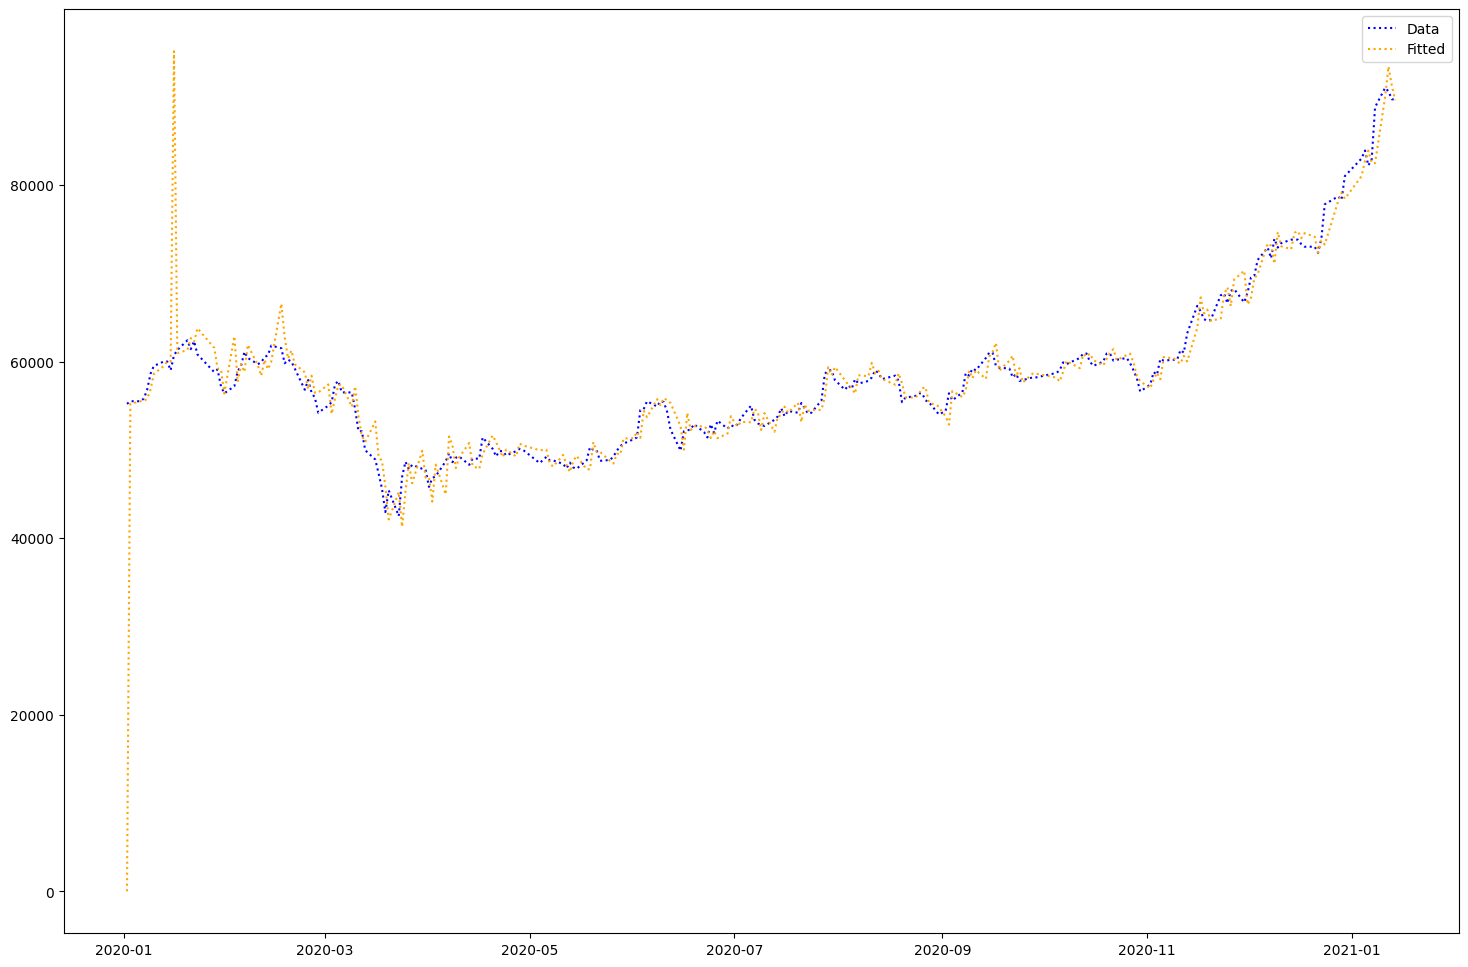

In [25]:
plt.figure(figsize=(18, 12))
plt.plot(train_data.index, train_data['price'], label = 'Data', color = 'blue', linestyle = ':')
plt.plot(train_data.index, SARIMAX_model_fit.predict(), label = 'Fitted', color = 'orange', linestyle = ':')
plt.legend()
plt.show()

In [26]:
forecast_sarimax = SARIMAX_model_fit.forecast(steps=len(test_data))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [27]:
forecast_sarimax

257     91527.888289
258     92809.138087
259     93390.704152
260     92440.978010
261     93129.687286
           ...      
317    128928.380210
318    129573.290444
319    129872.933651
320    129587.456281
321    130266.169407
Name: predicted_mean, Length: 65, dtype: float64

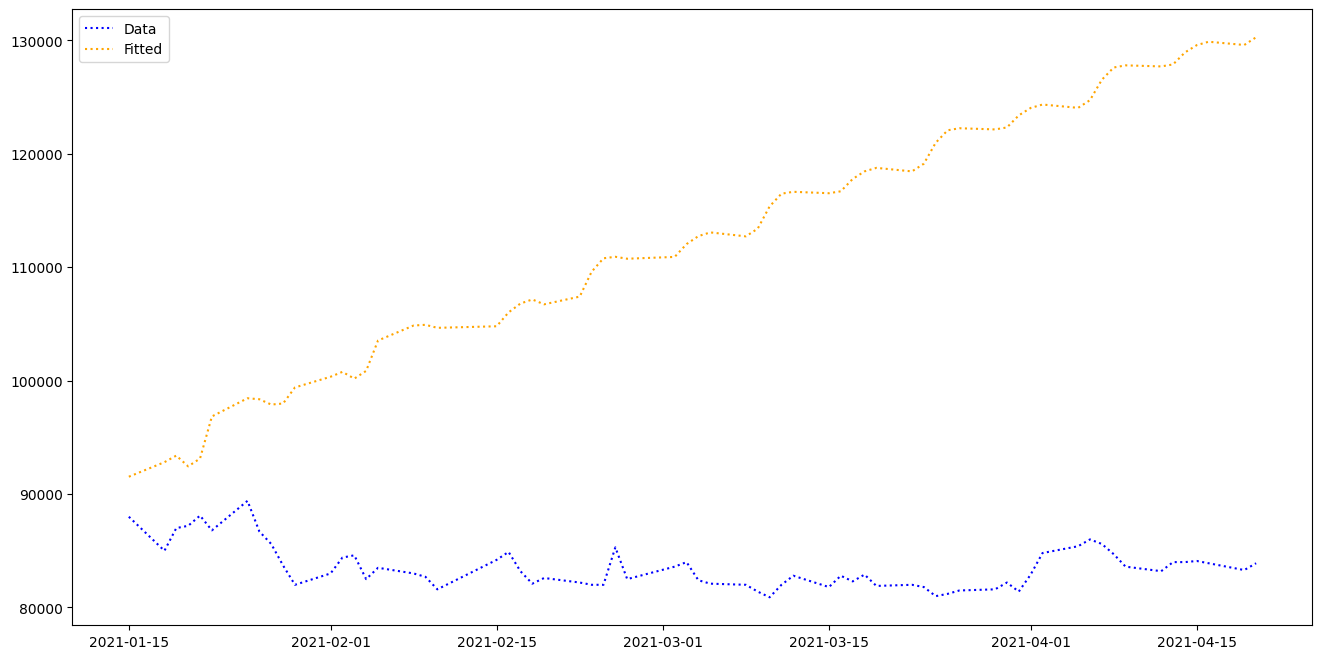

In [28]:
plt.figure(figsize = (16,8))
plt.plot(test_data.index, test_data['price'], label = 'Data', color = 'blue', linestyle = ':')
plt.plot(test_data.index, forecast_sarimax, label = 'Fitted', color = 'orange', linestyle = ':')
plt.legend()
plt.show()

In [46]:
from statsmodels.tools.eval_measures import rmse

sarimax_rmse_error = rmse(test_df['price'], forecast_sarimax)
sarimax_mse_error = sarimax_rmse_error**2
mean_value = samsung_df['price'].mean()

print(f'MSE Error: {sarimax_mse_error}\nRMSE Error: {sarimax_rmse_error}\nMean: {mean_value}')

MSE Error: 991110018.7867758
RMSE Error: 31481.899859868303
Mean: 63323.60248447205


SARIMAX 모델을 이용하여 예측한 결과, train 데이터의 계절성과 주기를 고려하여 향후 test index에서의 예측이 우상향하는 값을 가지는 것을 볼 수 있다. \

MSE-RMSE 값은 ARIMA 모델보다 훨씬 크게 측정되었다.

## Prophet

In [30]:
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

In [31]:
train_data_pr = train_data.copy()
train_data_pr = train_data_pr.reset_index()
train_data_pr.columns = ['ds', 'y']

test_data_pr = test_data.copy()
test_data_pr = test_data_pr.reset_index()
test_data_pr.columns = ['ds', 'y']

In [32]:
prophet_model = Prophet(seasonality_mode='multiplicative',
                        yearly_seasonality=True, weekly_seasonality=True,
                        daily_seasonality=True, changepoint_prior_scale=0.5)
prophet_model.fit(train_data_pr)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_b5cegos/81m8z66y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_b5cegos/uijengqo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=361', 'data', 'file=/tmp/tmp_b5cegos/81m8z66y.json', 'init=/tmp/tmp_b5cegos/uijengqo.json', 'output', 'file=/tmp/tmp_b5cegos/prophet_modelvgjovnwv/prophet_model-20230828123408.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:34:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:34:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [33]:
test_data_pr['ds']

0    2021-01-15
1    2021-01-18
2    2021-01-19
3    2021-01-20
4    2021-01-21
        ...    
60   2021-04-14
61   2021-04-15
62   2021-04-16
63   2021-04-19
64   2021-04-20
Name: ds, Length: 65, dtype: datetime64[ns]

In [35]:
future = prophet_model.make_future_dataframe(periods=len(test_data_pr))
future.tail()

,ds
317,2021-03-16
318,2021-03-17
319,2021-03-18
320,2021-03-19
321,2021-03-20


In [36]:
prophet_pred = prophet_model.predict(future)
prophet_pred.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
317,2021-03-16,7888.286891,-3410.914131,74450.217999,-623.549513,15892.512160,6.3602,6.3602,6.3602,3.704979,...,0.329271,0.329271,0.329271,-2.984491,-2.984491,-2.984491,0.0,0.0,0.0,37114.227354
318,2021-03-17,7885.195745,-4804.632571,75400.461381,-895.484497,16173.467053,6.3602,6.3602,6.3602,3.649123,...,0.336496,0.336496,0.336496,-3.047574,-3.047574,-3.047574,0.0,0.0,0.0,36659.241276
319,2021-03-18,7882.104599,-5371.020461,75321.575004,-1188.622512,16385.966614,6.3602,6.3602,6.3602,3.570452,...,0.309073,0.309073,0.309073,-3.098821,-3.098821,-3.098821,0.0,0.0,0.0,36024.778315
320,2021-03-19,7879.013453,-6392.582597,76009.869489,-1457.196010,16733.404797,6.3602,6.3602,6.3602,3.538535,...,0.314882,0.314882,0.314882,-3.136547,-3.136547,-3.136547,0.0,0.0,0.0,35759.174759
321,2021-03-20,7875.922306,-5990.374422,57645.604625,-1705.003375,17048.325547,6.3602,6.3602,6.3602,2.405993,...,-0.795025,-0.795025,-0.795025,-3.159182,-3.159182,-3.159182,0.0,0.0,0.0,26825.337240


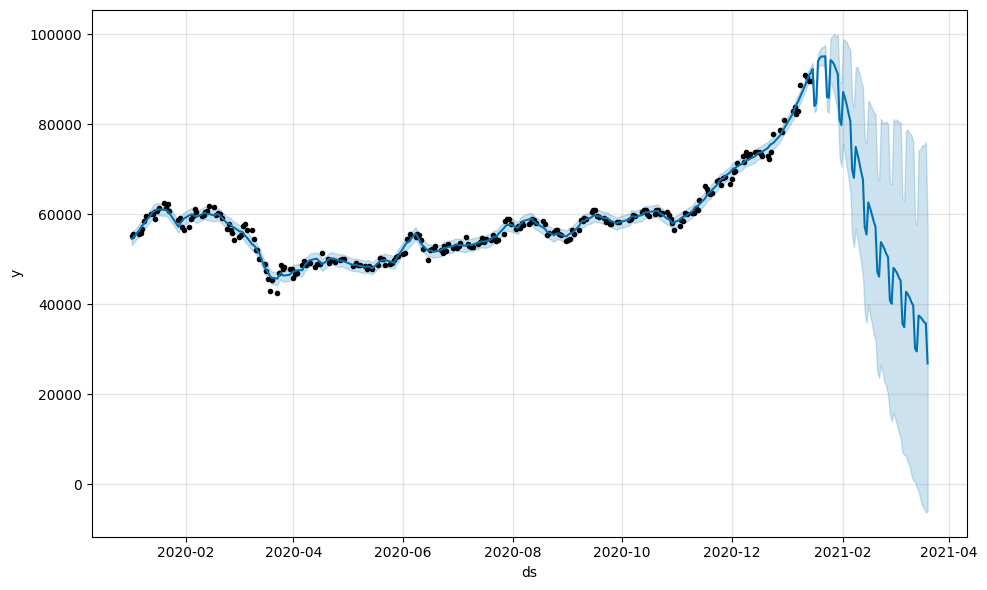

In [38]:
fig = prophet_model.plot(prophet_pred)

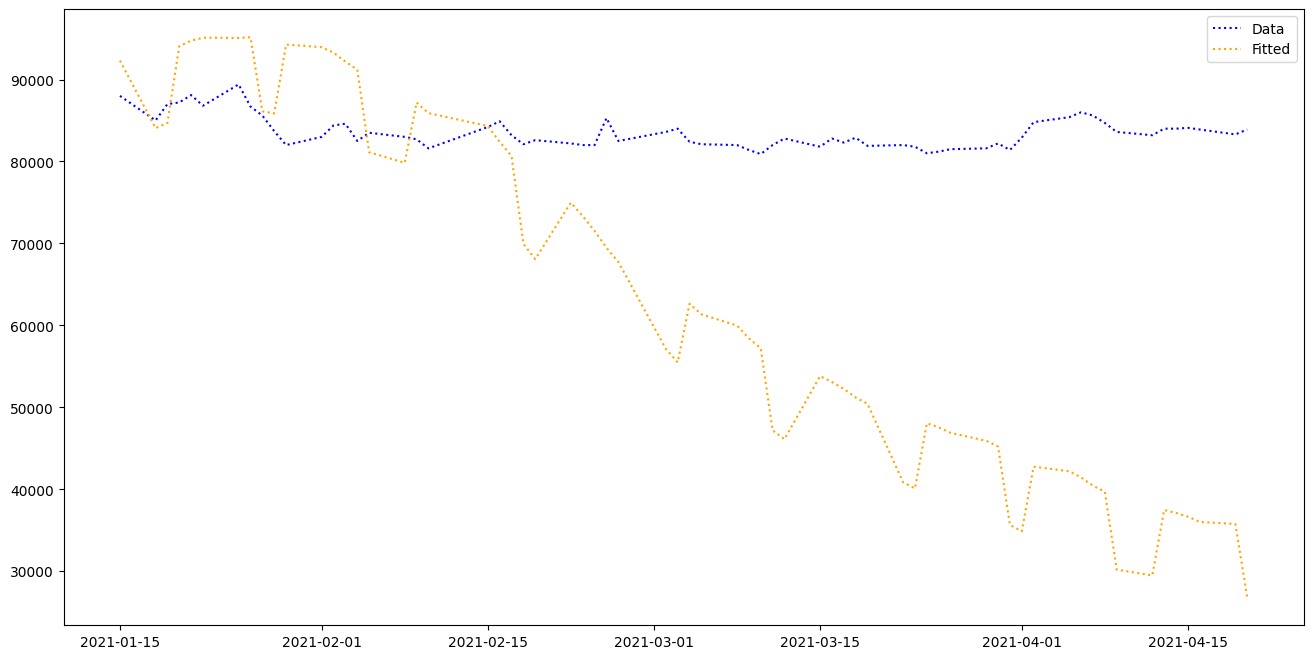

In [43]:
plt.figure(figsize = (16,8))
plt.plot(test_data.index, test_data['price'], label = 'Data', color = 'blue', linestyle = ':')
plt.plot(test_data.index, prophet_pred['yhat'][257:], label = 'Fitted', color = 'orange', linestyle = ':')
plt.legend()
plt.show()

In [47]:
from statsmodels.tools.eval_measures import rmse

prophet_rmse_error = rmse(test_df['price'], prophet_pred['yhat'][257:])
prophet_mse_error = prophet_rmse_error**2
mean_value = samsung_df['price'].mean()

print(f'MSE Error: {prophet_mse_error}\nRMSE Error: {prophet_rmse_error}\nMean: {mean_value}')

MSE Error: 871739118.7166468
RMSE Error: 29525.22851252208
Mean: 63323.60248447205


원본 test 데이터의 주가는 90000~80000 사이로 유지되지만 prophet을 통한 예측에서는 진동하며 감소하는 것으로 예측되었다. MSE-RMSE Error는 SARIMAX 모델보다 작지만 ARIMA 모델보단 크게 측정되었다.